In [1]:
import numpy as np
import scipy
import scipy.integrate
import scipy.interpolate
import matplotlib.pyplot as plt
import shared_functions_setup as setup
import shared_functions_wlp_wls as ws
import os.path
import pyccl as ccl
#import main.py as main

In [103]:
from importlib.metadata import version
version('pyccl')

'2.2.0'

- Need to fix some errors in main.py (missing certain files it is calling to, such as boosts txt file)

#### Set up cosmology and halo model quantities

In [ ]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,32)

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

#### Create new HOD class using NCen and NSat from Leonard2018 forecasting
- Need to double check with Danielle what is done here is correct!

In [ ]:
class HaloProfileHOD(ccl.halos.HaloProfileNFW):
    def __init__(self, c_M_relation,
                 lMmin=12.02, lMminp=-1.34,
                 lM0=6.6, lM0p=-1.43,
                 lM1=13.27, lM1p=-0.323):
        self.lMmin=lMmin
        self.lMminp=lMminp
        self.lM0=lM0
        self.lM0p=lM0p
        self.lM1=lM1
        self.lM1p=lM1p
        self.a0 = 1./(1+0.65)
        self.sigmaLogM = 0.4
        self.alpha = 1.
        super(HaloProfileHOD, self).__init__(c_M_relation)
        self._fourier = self._fourier_analytic_hod
    
    def _Nc(self, M, a):
        # Number of centrals

        return ws.get_Ncen_More(M, 'LSST_DESI')
    
    def _Ns(self, M, a):
        # Number of satellites

        return ws.get_Nsat_More(M, 'LSST_DESI')

    def _lMmin(self, a):
        return self.lMmin + self.lMminp * (a - self.a0)

    def _lM0(self, a):
        return self.lM0 + self.lM0p * (a - self.a0)

    def _lM1(self, a):
        return self.lM1 + self.lM1p * (a - self.a0)

    def _fourier_analytic_hod(self, cosmo, k, M, a, mass_def):
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
        
        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Nc[:, None] * (1 + Ns[:, None] * uk)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

    def _fourier_variance(self, cosmo, k, M, a, mass_def):
        # Fourier-space variance of the HOD profile
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Ns[:, None] * uk
        prof = Nc[:, None] * (2 * prof + prof**2)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

# this is the galaxy power spectrum calculated from the custom HOD????
pg = HaloProfileHOD(cM)

In [ ]:
# Halo model calculator
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

### Use new HOD to compute Galaxy-Galaxy power specturm 
- Only 1 term included? Check in meeting

In [ ]:
class Profile2ptHOD(ccl.halos.Profile2pt):
    def fourier_2pt(self, prof, cosmo, k, M, a,
                      prof2=None, mass_def=None):
        return prof._fourier_variance(cosmo, k, M ,a, mass_def)
HOD2pt = Profile2ptHOD()

# I think this includes 1 and 2 halo terms?    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

In [ ]:
plt.figure(figsize=([8,5]))
plt.plot(k_arr, pk_gg, label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);

### Create theoretical redshift distributions for lenses
- Convolve dn/dz with photo-z requirements from LSST SRD

In [ ]:
import customHOD as HOD

In [ ]:
pk_gg = HOD.get_GG_power()

In [ ]:
# this is a makeshift distribution maker based on the SRD 
# document for testing purposes

def get_LSST_dNdz(mode, year, z_arr):
    if year == 1 and mode == 'lens':
        z_0 = 0.26
        alpha = 0.94
        dNdz = z_arr**2 * np.exp(-(z_arr/z_0)**alpha)
    elif year == 10 and mode == 'lens':
        z_0 = 0.28
        alpha = 0.90
        dNdz = z_arr**2. * np.exp(-(z_arr/z_0)**alpha)
    elif year == 1 and mode == 'source':
        z_0 = 0.13
        alpha = 0.78
        dNdz = z_arr**2. * np.exp(-(z_arr/z_0)**alpha)
    elif year == 10 and mode == 'source':
        z_0 = 0.11
        alpha = 0.68
        dNdz = z_arr**2. * np.exp(-(z_arr/z_0)**alpha)
    else:
        print('Not an LSST release year')
        dNdz = 0.
        
    return dNdz

In [ ]:
lens_z_arr = np.linspace(0.2, 1.2, 256)
source_z_arr = np.linspace(0.2, 3.0, 256)

Y1lens_dNdz = get_LSST_dNdz(mode='lens', year=1, z_arr=lens_z_arr)
Y1source_dNdz = get_LSST_dNdz(mode='source', year=1, z_arr=source_z_arr)

lensTracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_arr, Y1lens_dNdz), 
                                    bias=(lens_z_arr, np.ones(len(lens_z_arr))))
matterTracer = ccl.WeakLensingTracer(cosmo, (source_z_arr, Y1source_dNdz))

In [ ]:
# create 2D power spectrum objects for galaxy-shear correlation

pk_gMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pg, prof2=pM, 
                                normprof1=True, normprof2=True, 
                                lk_arr=np.log(k_arr), a_arr=a_arr)

In [ ]:
ell = np.arange(2,2000)

y1_aps = ccl.angular_cl(cosmo, lensTracer, matterTracer, ell)

In [ ]:
plt.figure(figsize=[6,5])
plt.plot(ell, y1_aps)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{l}$', fontsize=14)
plt.xlabel(r'$\ell$', fontsize=14);

# Scripting and Streamlining HOD and gammaT calculation

### Explanation of LSST forecast data: https://github.com/CosmoLike/DESC_SRD

In [2]:
import spurious_george
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt

Initialised with Omega_c=0.265036, Omega_b=0.0491168, h=0.6726, sigma8=0.84, n_s=0.9652. Modify cosmology? Input y or n. n


In [3]:
import halo_model as halo
# define wavenumbers
k_arr = np.geomspace(1E-4,1E1,256)

# calculate galaxy-galaxy power spectrum
pk_gM = halo.get_1D_power('gm', k_arr, plot_fig='y')

In [4]:
z_s, dNdz_s = spurious_george.get_dNdz_spec(gtype='source', year=1)

norm = scipy.integrate.simps(dNdz_s, z_s)
#print(norm)

norm_dNdz_s = dNdz_s / norm

#print(norm_dNdz_s)

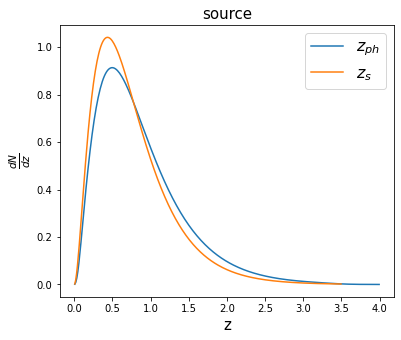

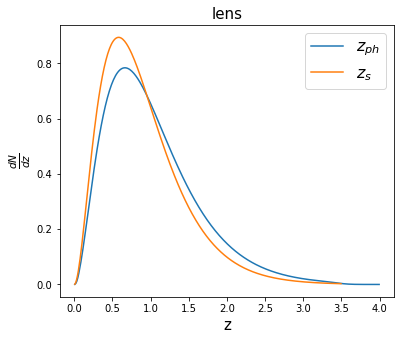

In [5]:
Sz_ph, SdNdz_ph, Sp_zs_zph = spurious_george.get_dNdz_phot(gtype='source', year=1, plot_fig='y')

Lz_ph, LdNdz_ph, Lp_zs_zph = spurious_george.get_dNdz_phot(gtype='lens', year=1, plot_fig='y')

 - Currently there is massive overlap of the lens and source samples. Need place upper and lower cuts and bin accordingly

### Estimating F
- Value of 0.02238294230501916 seems reasonable (DES Y1 was 0.07)
- Check integration points for num_integrand1 are correct (dz_s between z+ and z-)
- for r_p<2 Mpc, the projection length is defined to be 2 Mpc For larger r_p, projection length is r_p.

In [2]:
F = spurious_george.get_F(year=1)
print(F)

[0.00119782 0.00120335 0.00120891 0.0012145  0.00122011 0.00122575
 0.00123141 0.0012371  0.00124282 0.00124856 0.00125433 0.00126012
 0.00126595 0.0012718  0.00127767 0.00128358 0.00128951 0.00129546
 0.00130145 0.00130746 0.0013135  0.00131957 0.00132567 0.0013318
 0.00133795 0.00134413 0.00135034 0.00135658 0.00136285 0.00136915
 0.00137547 0.00138183 0.00138821 0.00139463 0.00140107 0.00140754
 0.00141405 0.00142058 0.00142714 0.00143374 0.00144036 0.00144702
 0.0014537  0.00146042 0.00146717 0.00147395 0.00148076 0.0014876
 0.00149447 0.00150138 0.00150831 0.00151528 0.00152228 0.00152932
 0.00153638 0.00154348 0.00155061 0.00155778 0.00156498 0.00157221
 0.00157947 0.00158677 0.0015941  0.00160147 0.00160887 0.0016163
 0.00162377 0.00163127 0.00163881 0.00164638 0.00165399 0.00166163
 0.00166931 0.00167702 0.00168477 0.00169255 0.00170037 0.00170823
 0.00171612 0.00172405 0.00173202 0.00174002 0.00174806 0.00175613
 0.00176425 0.0017724  0.00178059 0.00178882 0.00179708 0.0018053

- New code to estimate F(theta)

### Start by getting xi_ls
- We actually want everything in terms of theta

In [1]:
import pyccl as ccl
import time 
import numpy as np
import spurious_george 
import scipy 
import matplotlib.pyplot as plt
import shared_functions_setup as setup

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from IPython.display import clear_output

import macplotlib as macplot

halo_model: Initialised with Omega_c=0.265036, Omega_b=0.0491168, h=0.6726, sigma8=0.84, n_s=0.9652. Modify cosmology? Input y or n. n
spurious george: Please define poolsize to be used for parallelised functions 30


poolsize set to 30


macplotlib: Please define poolsize to be used for parallelised functions 30


poolsize set to 30


In [2]:
# set up different distance measures needed and weights
weights = spurious_george.compute_weights()
year = 1

# get spec-z for sources and lenses
z_s, dNdz_s = spurious_george.get_dNdz_spec(gtype='source', year=year)
z_l, dNdz_l = spurious_george.get_dNdz_spec(gtype='lens', year=year)

zleff = np.mean(z_l)

# find upper and lower IA redshift cuts
z_up, z_low = spurious_george.get_IA_zlims(year)

# get photometric redshift distribution
z_ph, dNdz_ph, p_zs_zph = spurious_george.get_dNdz_phot(gtype='source', year=year)

# convert redshifts for lenses and sources to scale factors
La_arr = 1. / (1. + z_l)
Sa_arr = 1. / (1. + z_s)

# comoving radial distance from observer to sources and lenses
chi_lens = ccl.comoving_radial_distance(spurious_george.halo.cosmo, La_arr) * (spurious_george.pa.HH0 / 100.)
chi_source = ccl.comoving_radial_distance(spurious_george.halo.cosmo, Sa_arr) * (spurious_george.pa.HH0 / 100.)

# need to flip array so highest z comes first for iteration routine below and because ccl wants scale factors backwards, 1 -> 0
chi_flipped = np.flip(chi_lens)

# L.o.S pair separation array
minPiPos = 10**(-3) 
max_int = 200. # We integrate the numerator out to 200 Mpc/h away from the lenses because the correlation is zero outside of this.
maxPiPos = max_int
Pi_pos = np.logspace(np.log10(minPiPos), np.log10(maxPiPos), 1000)

# Pi can be positive or negative, so now flip this and include the negative values, but only down to z=0
# And avoid including multiple of the same values - this messes up some integration routines.
Pi = [0]*len(z_l)
try:
    for zi in range(len(z_l)):
        Pi_pos_vec= list(Pi_pos)[1:]
        Pi_pos_vec.reverse()
        index_cut = next(j[0] for j in enumerate(Pi_pos_vec) if j[1]<=(chi_flipped[zi]-np.min(chi_source)))
        Pi[zi] = np.append(-np.asarray(Pi_pos_vec[index_cut:]), np.append([0],Pi_pos))  
except StopIteration:
    Pi[-1] = Pi_pos


In [ ]:
plt.figure()
plt.plot(chi_lens, z_l)

In [78]:
# define theta vector to convert to r_p and use in final plot
theta = np.logspace(np.log10(2.5), np.log10(250), 1000)

rpmin = setup.arcmin_to_rp(theta[0], zleff, spurious_george.halo.cosmo)
rpmax = setup.arcmin_to_rp(theta[-1], zleff, spurious_george.halo.cosmo)
print(rpmin, rpmax)

# set some arbitrary projected separations, r_p, for final xi_ls, requires rp < r
r_p = np.logspace(np.log10(rpmin), np.log10(rpmax), 1000)

rmax = np.sqrt(rpmax**2 + (maxPiPos+1)**2)
rmin = np.sqrt(rpmin**2 - minPiPos**2)
print(rmin, rmax)

# set some arbitrary 3D separations r to compute xi_gg
r = np.logspace(np.log10(rmin), np.log10(rmax), 1000)

# wavenumbers and scale factors for all-space power spectrum
k_arr = np.geomspace(1E-4,5E2,3000)

# must flip array because ccl wants scale factors ascending (z_0 == a_1)
pk_gg2D = spurious_george.halo.get_Pk2D('gg', k_arr=k_arr, a_arr=np.flip(La_arr))

3.5891633008301858 358.9163300830185
3.5891631615219497 411.36593441881195


In [63]:
def plot_pkgg(zl):
    
    pk_gg = pk_gg2D.eval(k_arr, np.flip(La_arr)[zl], cosmo=spurious_george.halo.cosmo)
       
    plt.figure(figsize=[6,5]);
    
    trace_steps = [20,40,60,80,100,120,140]
    for j in trace_steps:
        if zl-j >= 0:
            old_pk_gg = pk_gg2D.eval(k_arr, np.flip(La_arr)[zl-j], cosmo=spurious_george.halo.cosmo)
            plt.plot(k_arr, old_pk_gg, alpha=18/j, color='magenta')

    plt.plot(k_arr, pk_gg, color='magenta');
    plt.title(r'$z_{l} = %g$'%(np.flip(z_l[zl])), fontsize=15);
    plt.xlabel(r'$k / Mpc^{-1}$', fontsize=15);
    plt.ylabel(r'$P_{gg}(k)$', fontsize=15);
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,10**6])
    
    return

#macplot.gif_plot(func = plot_pkgg, loop_data=z_l, duration=30, gif_name='pkgg_test.gif')

In [64]:
interactive_plot = interactive(plot_pkgg, zl=(0, 299))
interactive_plot

interactive(children=(IntSlider(value=149, description='zl', max=299), Output()), _dom_classes=('widget-intera…

In [65]:
# use 2D power spectrum and lens-source 3D separations to get 3D correlation function xi_ls(r,z_l)
xi_gg = np.zeros([len(r), len(z_l)])
for zl in range(len(z_l)):
    xi_gg[:,zl] = ccl.correlations.correlation_3d(spurious_george.halo.cosmo, np.flip(La_arr[zl]), 
                                       r, pk_gg2D)

In [66]:
def plot(zl):

    plt.figure(figsize=[6,5]);
    plt.plot(r, xi_gg[:,zl], linewidth=1);
    plt.title(r'$z_{l} = %g$'%(np.flip(z_l)[zl]), fontsize=15);
    plt.xlabel(r'$\hat{r}$', fontsize=15);
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$\xi_{gg}(\hat{r})$', fontsize=15);

interactive_plot = interactive(plot, zl=(0, 299))
interactive_plot

interactive(children=(IntSlider(value=149, description='zl', max=299), Output()), _dom_classes=('widget-intera…

#### We want xi_ls(r_p, Pi(z_s); z_l) so we need to interpolate xi_ls(r, z_l) across r_p and Pi(z_s)

In [67]:
# ccl utilises multiple cores, but a standard for loop is single threaded. Itertools
# doesn't have much to speed up our runtime so we're going to try compute xi_ls at multiple values
# simultaneously using mulitple threads
import multiprocessing as mp 

# define function used to calculate xi_ls(r,Pi) at fixed zl
def calculate_xi_ls(zl, r, r_p, Pi, xi_gg):
    # xi_gg is a function of r, so we interpolate it across r to later find x_ls as a function of rp and pi
    xi_interp_r = scipy.interpolate.interp1d(r, xi_gg[:, zl])
    # preallocate array for xi(rp,pi(zl))
    xi_ofPi = np.zeros((len(r_p), len(Pi[zl])))
    for ri in range(len(r_p)):
        for pi in range(len(Pi[zl])):
            rp_pi_zl = np.sqrt((r_p[ri]**2 + Pi[zl][pi]**2))
            xi_ofPi[ri, pi] = xi_interp_r(rp_pi_zl)
    
    return xi_ofPi

# wrap function inside another function so it can be passsed to multiprocessing with a single set
# of iterables
global wrap_for_mp
def wrap_for_mp(iterable):
    return calculate_xi_ls(zl=iterable, r=r, r_p=r_p, Pi=Pi, xi_gg=xi_gg), iterable

# how many iterations do you want it done in?
iteration_number = 10

# set size of pool used, easier to define this way so we optimise number of processes 
# allocated
poolsize = int(len(z_l) / iteration_number)

# preallocate list for outputs
xi_ls = [0] * len(z_l)

# set first set of indices to be passed to multiprocessing and computed 
iterables = list(range(len(z_l)))

# open multiprocess pool in with statement so it closes after it's complete
start = time.time()
with mp.Pool(poolsize) as p:
    # output values and process ID (imap should ensure correct order)
    xi_ls, order = zip(*p.imap(wrap_for_mp, iterables))

# run quick test to ensure order of outputs was preserved
check_order = list(order)
if check_order == iterables:
    print('Order preserved for zl indices %d-%d'%(iterables[0],iterables[-1]))
else:
    print('Order scrambled, data corrupted, exiting...')
    exit()
    
print('Shape of xi_ls output is ', len(xi_ls))
end = time.time()
print('Runtime: %g minutes'%((end-start)/60))

Order preserved for zl indices 0-299
Shape of xi_ls output is  300
Runtime: 5.90436 minutes


### Make GIF of xi_ls vs r_p, varying with Pi to verify output

In [ ]:
# import os
# from PIL import Image

# frames = []

# #need to use for loop as python sort function doesn't sort strings numerically
# for i in range(len(Pi[149])):
#     if abs(Pi[149][i]) >= 0.1:
#         plt.figure(figsize=[6,5]);
#         plt.plot(r_p, xi_ls[149][:,i]);
#         plt.title(r'$z_{l} = %g, \Pi = %g$'%(z_l[149], Pi[149][i]), fontsize=15);
#         plt.xlabel(r'$r_{p}$', fontsize=15);
#         plt.ylabel(r'$\xi_{ls}(r_{p}, \Pi, z_{l})$', fontsize=15);
#         plt.savefig('frame%d.png'%i, dpi=100);
#         plt.close()
#         frames.append(Image.open('frame%d.png'%i))
#         os.remove('frame%d.png'%i)
#     else:
#         pass

# # Save into a gif file that loops forever
# frames[0].save('xi_ls_ofPi.gif', format='GIF',
#                 append_images=frames[1:], save_all=True, duration=100,
#                 loop=0)

### z_l ORDER in xi_ls is FLIPPED, xi_ls[0] = max_z_l etc.

In [68]:
def plot(zl, pi):

    plt.figure(figsize=[6,5]);
    plt.plot(r_p, xi_ls[zl][:,pi]);
    plt.title(r'$z_{l} = %g, \Pi = %g$'%(np.flip(z_l)[zl], Pi[zl][pi]), fontsize=15);
    plt.xlabel(r'$r_{p}$', fontsize=15);
    plt.xscale('log')
    plt.ylabel(r'$\xi_{ls}(r_{p}, \Pi, z_{l})$', fontsize=15);

interactive_plot = interactive(plot, zl=(0, 299), pi=(0,1999))
interactive_plot

interactive(children=(IntSlider(value=149, description='zl', max=299), IntSlider(value=999, description='pi', …

In [69]:
com_Pi = [0]*len(z_l)
z_Pi = [0]*len(z_l)
# get comoving distance values associated to Pi
for zl in range(len(z_l)):
    com_Pi[zl] = chi_flipped[zl] + Pi[zl]
    # CCL wants distance in Mpc but we are working in Mpc/h
    z_Pi[zl] = (1./ccl.scale_factor_of_chi(spurious_george.halo.cosmo, com_Pi[zl] / (spurious_george.pa.HH0_t/100.))) - 1. 
    
del com_Pi

In [ ]:
# # Need to interpolate dNdz_s over the z_Pi values

# dNdz_Pi_interp = [0] * len(z_l)

# # need to do a little bit of extrapolation as z_Pi extends beyond z_s max redshift
# interp = scipy.interpolate.interp1d(np.flip(z_s), np.flip(dNdz_s), 
#                                     bounds_error=False, fill_value='extrapolate')

# for zl in range(len(z_l)):
#     dNdz_Pi_interp[zi] = interp(z_Pi[zl]) 

In [70]:
# Or do we? We could just take SRD Gaussian parameterisation and construct dNdz_Pi using that,
# then convolve with error dist to get P(z_Pi, z_ph). Perhaps this will be more represenatative than
# interpolating

# set best fit values based on survey year 
if year == 1:
    z0 = 0.26
    alpha = 0.94
elif year == 10:
    z0 = 0.28
    alpha = 0.98
else: 
    print('Not a current survey year')
    exit()
    
# start by constructing dNdz_Pi using SRD parameterisation
dNdz_Pi = [0] * len(z_l)
for zi in range(len(z_l)):
    dNdz_Pi[zi] = z_Pi[zi]**2 * np.exp(-(z_Pi[zi]/z0) ** alpha)

# next get error dist p_zPi_zph

p_zPi_zph = [0] * len(z_l)
# first loop over z_Pi values for each lens redshift
for zl in range(len(z_l)):
    # define photo-z shift value for each zl
    chi_plus = ccl.comoving_radial_distance(spurious_george.halo.cosmo, 
                                        1./(1. + np.max(z_Pi[zl]))) * (spurious_george.pa.HH0/100.) + np.max(Pi[zl])
    a_plus = ccl.scale_factor_of_chi(spurious_george.halo.cosmo, chi_plus / (spurious_george.pa.HH0/100.))
    zph_plus = (1. / a_plus) - 1.
    # set arbitrary photo-z values in range of z_Pi boosted by 200Mpc in z                                 
    zPi_ph = np.linspace(np.min(z_Pi[zl]), zph_plus, len(z_Pi[zl]))
    # variance for each z_Pi
    sig_z = 0.05*(1. + z_Pi[zl])
    p = np.zeros([len(zPi_ph), len(z_Pi[zl])])
    # loop over specific z_Pi values to find error dist for each z_Pi
    for zi in range(len(z_Pi[zl])):
        # create 2D array of z_ph probability at each z_Pi
        p[zi,:] =  1. / (np.sqrt(2. * np.pi) * sig_z) * np.exp(-((zPi_ph - z_Pi[zl][zi])**2) / (2. * sig_z**2))
    # save p(z_Pi,z_ph) at each lens redshift
    p_zPi_zph[zl] = p

In [71]:
print(np.max(z_Pi[0]))
chi = ccl.comoving_radial_distance(spurious_george.halo.cosmo, 
                                        1./(1. + np.max(z_Pi[0]))) * (spurious_george.pa.HH0/100.)

chi_plus = ccl.comoving_radial_distance(spurious_george.halo.cosmo, 
                                        1./(1. + np.max(z_Pi[0]))) * (spurious_george.pa.HH0/100.) + np.max(Pi[0])

a_plus = ccl.scale_factor_of_chi(spurious_george.halo.cosmo, chi_plus / (spurious_george.pa.HH0/100.)) 

z_plus = (1. / a_plus) - 1.
print(z_plus)

3.877317859674112
4.31059983267158


In [72]:
print(np.max(z_Pi[-1]))
chi = ccl.comoving_radial_distance(spurious_george.halo.cosmo, 
                                        1./(1. + np.max(z_Pi[-1]))) * (spurious_george.pa.HH0/100.)

chi_plus = ccl.comoving_radial_distance(spurious_george.halo.cosmo, 
                                        1./(1. + np.max(z_Pi[-1]))) * (spurious_george.pa.HH0/100.) + np.max(Pi[-1])

a_plus = ccl.scale_factor_of_chi(spurious_george.halo.cosmo, chi_plus / (spurious_george.pa.HH0/100.))

z_plus = (1. / a_plus) - 1.
print(z_plus)

0.07383999491999993
0.14426866692544982


- Now we have dNdz_Pi and P(z_pi, z_ph), so we can treat z_s as z_pi

### Compute integrals
- First we will define functions to solve the integrals over z_pi and z_ph
- Then we will parallelise these to compute the integrals for $B_{zl}$(rp) - 1 for all z_l values
- Finally we will integrate over z_l to leave us with a len(rp) vector representing B(rp) - 1 
#### Check photo-z definition of +0.2 with Danielle!

In [73]:
def integrate_zPi(zl):
    # preallocate arrays to store data
    igl_zPi = np.zeros([len(r_p), len(z_Pi[zl])])
    num_igd_zPi = np.zeros([len(z_Pi[zl]), len(z_Pi[zl])])
    denom_igd_zPi = np.zeros([len(z_Pi[zl]), len(z_Pi[zl])])
    for ri in range(len(r_p)):
        # rows are rp, columns represent different Pi values
        num_igd_zPi = dNdz_Pi[zl] * xi_ls[zl][ri,:] * p_zPi_zph[zl]
        denom_igd_zPi = dNdz_Pi[zl] * p_zPi_zph[zl]
        # for P(zpi,zph), we want to integrate over the z_Pi values, these are rows so axis=0
        igl_zPi[ri,:] = scipy.integrate.simps(num_igd_zPi, z_Pi[zl], axis=0) / scipy.integrate.simps(denom_igd_zPi, z_Pi[zl])
    
    # this leaves us with an array that is [len(rp) x len(zph)]
    return igl_zPi

def integrate_zph(zl):
    # now we want to integrate over zph, so we need array to store integrals for different rp
    igl_zph = np.zeros([len(r_p)])
    # arbitrarily define photometric redshifts slightly extended in range from zPi
    chi_plus = ccl.comoving_radial_distance(spurious_george.halo.cosmo, 
                                        1./(1. + np.max(z_Pi[zl]))) * (spurious_george.pa.HH0/100.) + np.max(Pi[zl])
    a_plus = ccl.scale_factor_of_chi(spurious_george.halo.cosmo, chi_plus / (spurious_george.pa.HH0/100.))
    zph_plus = (1. / a_plus) - 1. 
    zPi_ph = np.linspace(np.min(z_Pi[zl]), zph_plus, len(z_Pi[zl]))
    # call to previous function to get first integral
    igd_zph = weights * integrate_zPi(zl)
    # integrate over zph for a certain zl, zph are the columns so specify axis=1
    igl_zph = scipy.integrate.simps(igd_zph, zPi_ph, axis=1) / scipy.integrate.simps(weights * np.ones([len(zPi_ph)]), zPi_ph)
    
    # return len(rp) array representing [B(rp) - 1] at zl 
    return igl_zph, zl


In [74]:
# parallelised integration routine
iterables = list(range(len(z_l)))

poolsize = 30

# allocate array to store [B(rp) - 1] for each zl
igl_zph = np.zeros([len(z_l), len(r_p)])

start = time.time()
with mp.Pool(poolsize) as p:
    # output values and process ID (imap should ensure correct order)
    igl_zph, order = zip(*p.map(integrate_zph, iterables))

# run quick test to ensure order of outputs was preserved
check_order = list(order)
if check_order == iterables:
    print('Order preserved for zl indices %d-%d'%(iterables[0],iterables[-1]))
else:
    print('Order scrambled, data corrupted, exiting...')
    exit()
    
# replace NaN with 0. NaN is produced due to divide by zero error 
#resulting from Pi[-1][:] = 0
if np.isnan(igl_zph[-1], out=np.empty(len(igl_zph[-1]))).all() == True:
    igl_zph[-1][:] = np.zeros([len(igl_zph[-1])])

# All [B(rp) - 1]_zl have been collected into a [len(z_l) x len(r_p)] array 
# We must flip along the rows as previous integrals were collected with zl descending, 
# but we integrate over an ascending sample
igd_zl = np.flip(igl_zph, axis=0) * dNdz_l[:,None]
igl_zl = scipy.integrate.simps(igd_zl, z_l, axis=0) / scipy.integrate.simps(dNdz_l, z_l)

np.savez('boost_test', B_min1 = igl_zl, B = igl_zl - 1., rp = r_p)

end = time.time()
print('Runtime = %g'%(end-start))

Order preserved for zl indices 0-299
Runtime = 4042.75


Text(0, 0.5, '$B(r_{p}) - 1$')

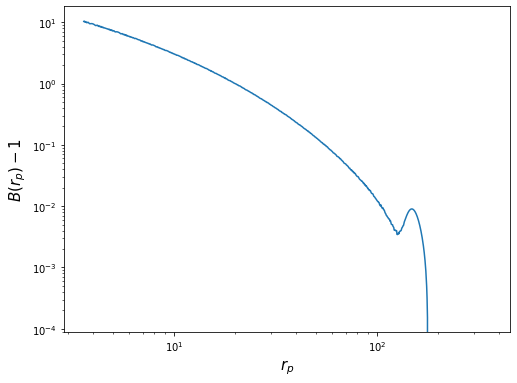

In [75]:
plt.figure(figsize=[8,6])
plt.plot(r_p, igl_zl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r_{p}$', fontsize=15)
plt.ylabel(r'$B(r_{p}) - 1$', fontsize=15)

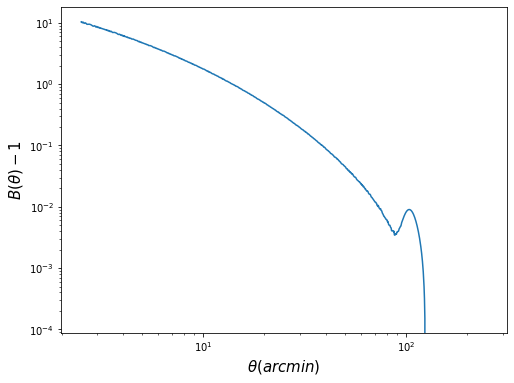

In [80]:
B_min1 = np.load('boost_test.npz')['B_min1']

def plot():
    plt.figure(figsize=[8,6])
    plt.plot(theta, B_min1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\theta (arcmin)$', fontsize=15)
    plt.ylabel(r'$B(\theta) - 1$', fontsize=15)
    
plot()
plt.savefig('b_min1_theta.png', dpi=300)

In [ ]:
# tests for single zl value

### Old paralleisation code that doesn't really work but I'm keeping just in case the new thing is completely wrong

In [ ]:
# # make sure process doesn't run beyond length of zl array 
# while iterables[-1] < len(z_l):
    
#     # open multiprocess pool in with statement so it closes after it's complete
#     with mp.Pool(poolsize) as p:
#         # output values and process ID (imap should ensure correct order)
#         xi_ofPi, order = zip(*p.imap(wrap_for_mp, iterables))

#     # run quick test to ensure order of outputs was preserved
#     check_order = list(order)
#     if check_order == iterables:
#         print('Order preserved for zi values %d-%d'%(iterables[0],iterables[-1]))
#     else:
#         print('Order scrambled, data corrupted, exiting...')
#         break
        
#     print(np.shape(xi_ofPi))
#     # set corresponding positions in xi_ls == xi_ofPi
#     start_index = iterables[0]
#     xi_ls[iterables[0:30]] = xi_ofPi
    
#     # increase values of iterables array for next set of iterations
#     iterables = [i + poolsize for i in iterables]

### Original Interpolation Code

In [ ]:
# xi_interp_r = [0] * len(z_l)
# xi_ofPi = [0] * len(z_l)

# for zl in range(len(z_l)):
#     # xi_gg is a function of r, so we interpolate it across r to later find x_ls as a function of rp and pi
#     xi_interp_r[zl] = scipy.interpolate.interp1d(r, xi_gg[:, zl])
#     # preallocate array for xi(rp,pi(zl))
#     xi_ofPi[zl] = np.zeros((len(r_p), len(Pi[zl])))
#     for ri in range(len(r_p)):
#         for pi in range(len(Pi[zl])):
#             rp_pi_zl = np.sqrt((r_p[ri]**2 + Pi[zl][pi]**2))
#             xi_ofPi[zl][ri, pi] = xi_interp_r[zl](rp_pi_zl)